# Segmentación y análisis de clientes

Para el desarrollo de este trabajo, se ha utilizado el dataset Mall_Customers.csv de Kaggle.com, basado en su descripción oficial podemos encontrar:

"Contexto

Este conjunto de datos se creó únicamente con el propósito de aprender los conceptos de segmentación de clientes, también conocidos como análisis de la cesta de la compra. (...)

Contenido

Eres dueño de un centro comercial de supermercados y, a través de las tarjetas de membresía, tienes algunos datos básicos sobre tus clientes, como la identificación del cliente, la edad, el sexo, los ingresos anuales y la puntuación de gasto.
La puntuación de gasto es algo que asignas al cliente en función de tus parámetros definidos, como el comportamiento del cliente y los datos de compra.

Enunciado del problema
Eres dueño del centro comercial y quieres comprender a los clientes, como quiénes pueden converger fácilmente [clientes objetivo] para que el equipo de marketing tenga la idea y planifique la estrategia en consecuencia."

#### Pasos para reesolver el problema :

- Importar librerías.
- Exploración de los datos.
- Visualización de los datos.
- Clustering usando K-Means.
- 3D Plot de los Clusters.
- Selección de Clusters [clientes objetivo].
- Conclusiones finales

### Impotando Librerías

In [5]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 

sns.set() 

### Exploración de los datos

In [7]:
raw_data = pd.read_csv('Mall_Customers.csv')
raw_data.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [8]:
raw_data.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [9]:
raw_data.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [10]:
raw_data.dtypes

CustomerID                 int64
Gender                    object
Age                        int64
Annual Income (k$)         int64
Spending Score (1-100)     int64
dtype: object

In [11]:
# Trabajamos con un respaldo
data = raw_data.copy()

# Convertir la variable categórica "Gender" a valores numéricos para facilitar el análisis estadístico.
data['Gender'] = data['Gender'].map({'Male': 0, 'Female': 1})
# Dropear la columna CustomerID ya que no aporta información relevante
data = data.drop(columns=['CustomerID'])

data.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,0,19,15,39
1,0,21,15,81
2,1,20,16,6
3,1,23,16,77
4,1,31,17,40


### Influirá significativamente el género en este análisis?

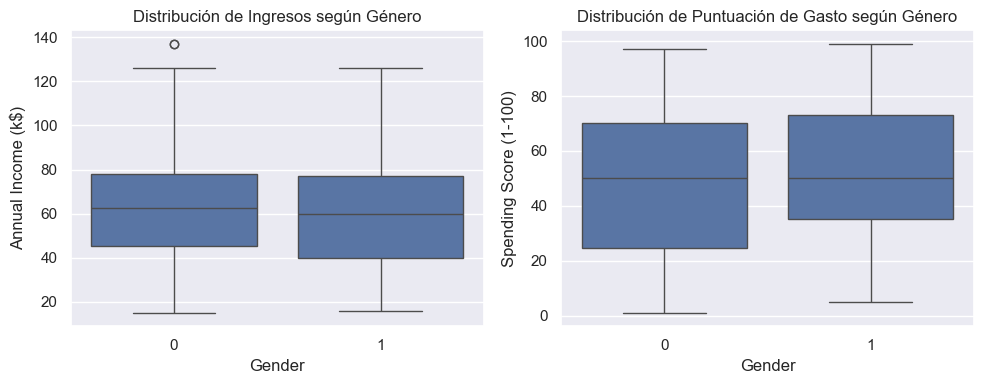

In [13]:
# Crear figura con dos gráficos en la misma fila
fig, axes = plt.subplots(1, 2, figsize=(10, 4))  

# Boxplot para Annual Income
sns.boxplot(x='Gender', y='Annual Income (k$)', data=data, ax=axes[0])
axes[0].set_title("Distribución de Ingresos según Género")

# Boxplot para Spending Score
sns.boxplot(x='Gender', y='Spending Score (1-100)', data=data, ax=axes[1])
axes[1].set_title("Distribución de Puntuación de Gasto según Género")

plt.tight_layout()  # Ajusta el espacio entre los gráficos
plt.show()

Basándonos en el gráfico:
- Ingresos: La distribución entre géneros es similar, con pequeñas diferencias en algunos rangos.
- Spending Score: Diferencia más notable, ya que los hombres tienen un rango más amplio de gasto comparado con las mujeres

In [15]:
# Ahora evaluaremos estadísticamente si ésta diferencia es relevante para el análisis:
from scipy.stats import mannwhitneyu

# Separar datos por género
male_spending = data[raw_data['Gender'] == 'Male']['Spending Score (1-100)']
female_spending = data[raw_data['Gender'] == 'Female']['Spending Score (1-100)']

# Prueba estadística
stat, p = mannwhitneyu(male_spending, female_spending, alternative='two-sided')
print(f'Estadístico de prueba: {stat}, p-valor: {p}')

Estadístico de prueba: 4697.5, p-valor: 0.5712794188160656


- El p-valor de 0.57, muestra que no hay evidencia estadísticamente significativa de que el género influya en el Spending Score.
- Es por esto que vamos a omitir Gender en el análisis estadístico.

In [17]:
# Calcular los z-scores
from scipy.stats import zscore

z_scores = data[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].apply(zscore)

# Calcular el promedio del valor absoluto del z-score para cada columna
mean_abs_z_scores = z_scores.abs().mean()

# Mostrar resultados
print(mean_abs_z_scores)

Age                       0.836835
Annual Income (k$)        0.801894
Spending Score (1-100)    0.808498
dtype: float64


- Como los valores no están cerca de 0, pero tampoco superan 1, podríamos decir que hay algo de dispersión, pero no tan extrema.
- Para K-Means, generalmente sí es recomendable estandarizar porque la métrica de distancia euclidiana se ve afectada por las diferencias de escala.

### Estandarizar los datos

In [20]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']])

# Convertir a DataFrame para mejor visualización
data_scaled = pd.DataFrame(data_scaled, columns=['Age', 'Annual Income (k$)', 'Spending Score (1-100)'])

# Revisar Media y desviación estándar
data_scaled.describe().round(2)

,Age,Annual Income (k$),Spending Score (1-100)
count,200.00,200.00,200.00
mean,-0.00,-0.00,-0.00
std,1.00,1.00,1.00
min,-1.50,-1.74,-1.91
25%,-0.72,-0.73,-0.60
50%,-0.20,0.04,-0.01
75%,0.73,0.67,0.89
max,2.24,2.92,1.89


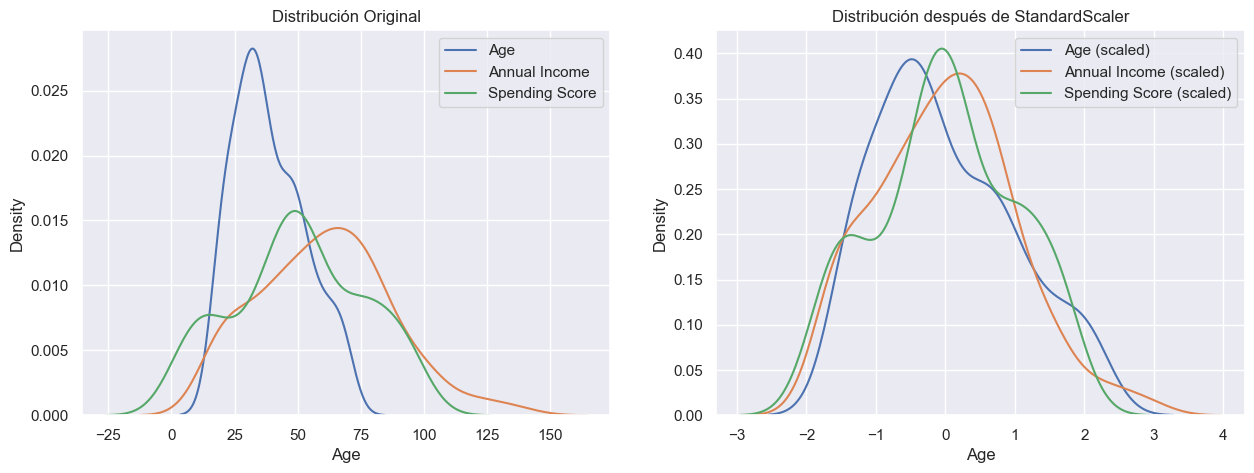

In [21]:
# Gráfico de densidad antes vs después de la estandarización
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Gráficos antes de escalar
sns.kdeplot(data['Age'], label='Age', ax=axes[0])
sns.kdeplot(data['Annual Income (k$)'], label='Annual Income', ax=axes[0])
sns.kdeplot(data['Spending Score (1-100)'], label='Spending Score', ax=axes[0])
axes[0].set_title("Distribución Original")
axes[0].legend()

# Gráficos después de escalar
sns.kdeplot(data_scaled['Age'], label='Age (scaled)', ax=axes[1])
sns.kdeplot(data_scaled['Annual Income (k$)'], label='Annual Income (scaled)', ax=axes[1])
sns.kdeplot(data_scaled['Spending Score (1-100)'], label='Spending Score (scaled)', ax=axes[1])
axes[1].set_title("Distribución después de StandardScaler")
axes[1].legend()

plt.show()

### Evaluar la correlación entre variables

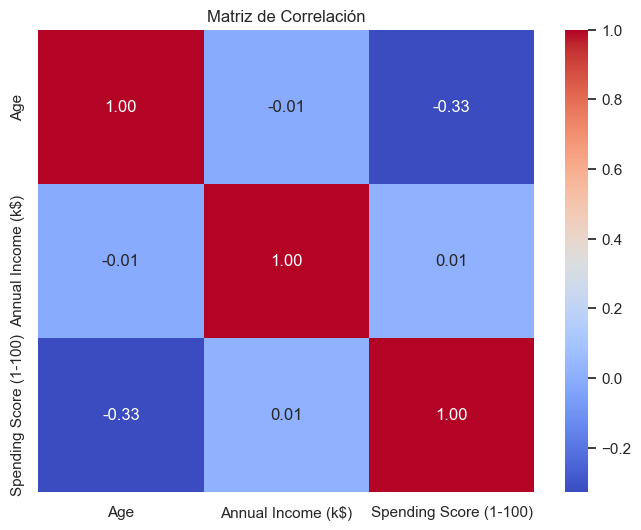

In [23]:
# Antes de aplicar clustering, vamos a revisar si hay colinealidad entre variables.
# Si dos variables están muy correlacionadas, podrían aportar información redundante, por tanto omitible.

plt.figure(figsize=(8,6))
sns.heatmap(data_scaled.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlación")
plt.show()

Análisis:
- Age vs Spending Score (-0.33) → A mayor edad, menor gasto en promedio (no estrictamente).
- Annual Income vs Age (-0.01) → La edad no influye en los ingresos.
- Spending Score vs Annual Income (0.01) → Los ingresos no determinan cuánto gasta un cliente.

### Aplicar K-Means

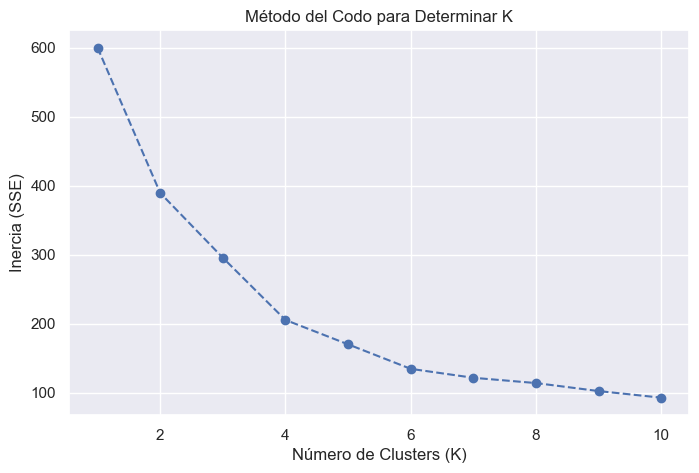

In [26]:
# Aplicamos la métodología del codo para evaluar el valor de k en K-Means
from sklearn.cluster import KMeans

# Definir el rango de K a evaluar
K_range = range(1, 11)

# Lista para almacenar la inercia de cada K
inertia_values = []

# Ejecutar K-Means para cada valor de K
for k in K_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans.fit(data_scaled)  # Asegúrate de usar datos escalados
    inertia_values.append(kmeans.inertia_)

# Graficar la inercia para ver el "codo"
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia_values, marker='o', linestyle='--', color='b')
plt.xlabel("Número de Clusters (K)")
plt.ylabel("Inercia (SSE)")
plt.title("Método del Codo para Determinar K")
plt.show()

Tanto para K=4 como para K=6 veo notable aplanamiento de la Inercia, vamos a complementarlo con el método de la silueta:

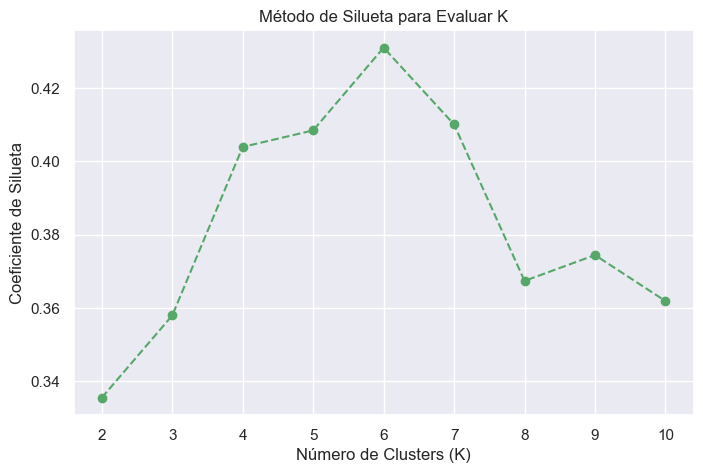

In [28]:
from sklearn.metrics import silhouette_score

# Evaluar silueta para los valores de K entre 2 y 10
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    labels = kmeans.fit_predict(data_scaled)  # Obtener etiquetas de cluster
    score = silhouette_score(data_scaled, labels)  # Calcular coeficiente de silueta
    silhouette_scores.append(score)

# Graficar los coeficientes de silueta
plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), silhouette_scores, marker='o', linestyle='--', color='g')
plt.xlabel("Número de Clusters (K)")
plt.ylabel("Coeficiente de Silueta")
plt.title("Método de Silueta para Evaluar K")
plt.show()

Con esto confirmamos que el coeficiente de silueta alcanza su punto más alto en K=6, lo que significa que con 6 clusters se logra la mejor separación y cohesión de los datos

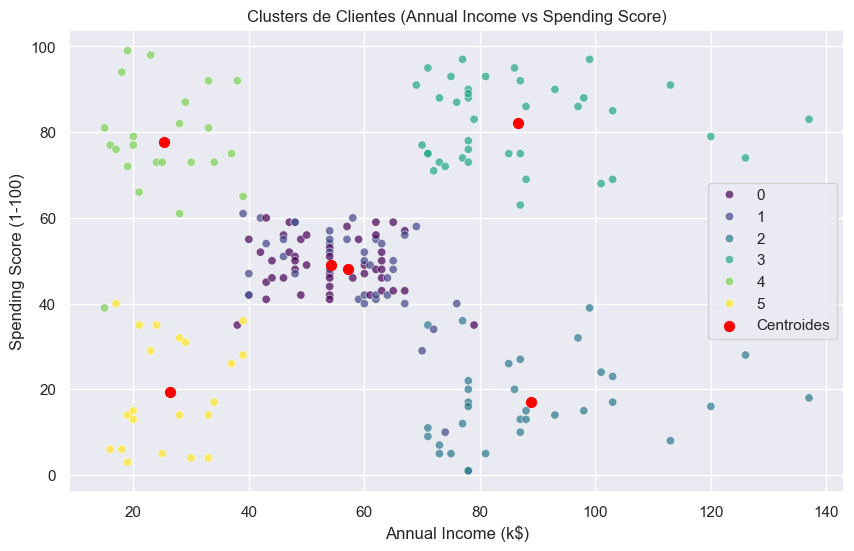

In [30]:
from sklearn.cluster import KMeans

# Aplicar K-Means con K=6
kmeans = KMeans(n_clusters=6, random_state=42, n_init=10)
data['Cluster'] = kmeans.fit_predict(data_scaled)

# Visualización de clusters en 2D
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=data['Annual Income (k$)'], 
    y=data['Spending Score (1-100)'], 
    hue=data['Cluster'], 
    palette='viridis', 
    alpha=0.7
)

# Centroides
means = scaler.mean_
stds = scaler.scale_
# Desescalar los centroides
centroids = kmeans.cluster_centers_ * stds + means

# Graficar los centroides correctamente
plt.scatter(centroids[:, 1],  # Eje X: Annual Income
            centroids[:, 2],  # Eje Y: Spending Score
            c='red', marker='.', s=200, label="Centroides")


plt.title('Clusters de Clientes (Annual Income vs Spending Score)')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.legend()
plt.show()

Considerando que de los clusters identificados existen 2 casi mezclados, es necesario considerar un gráfico 3D para ver si se separan mejor

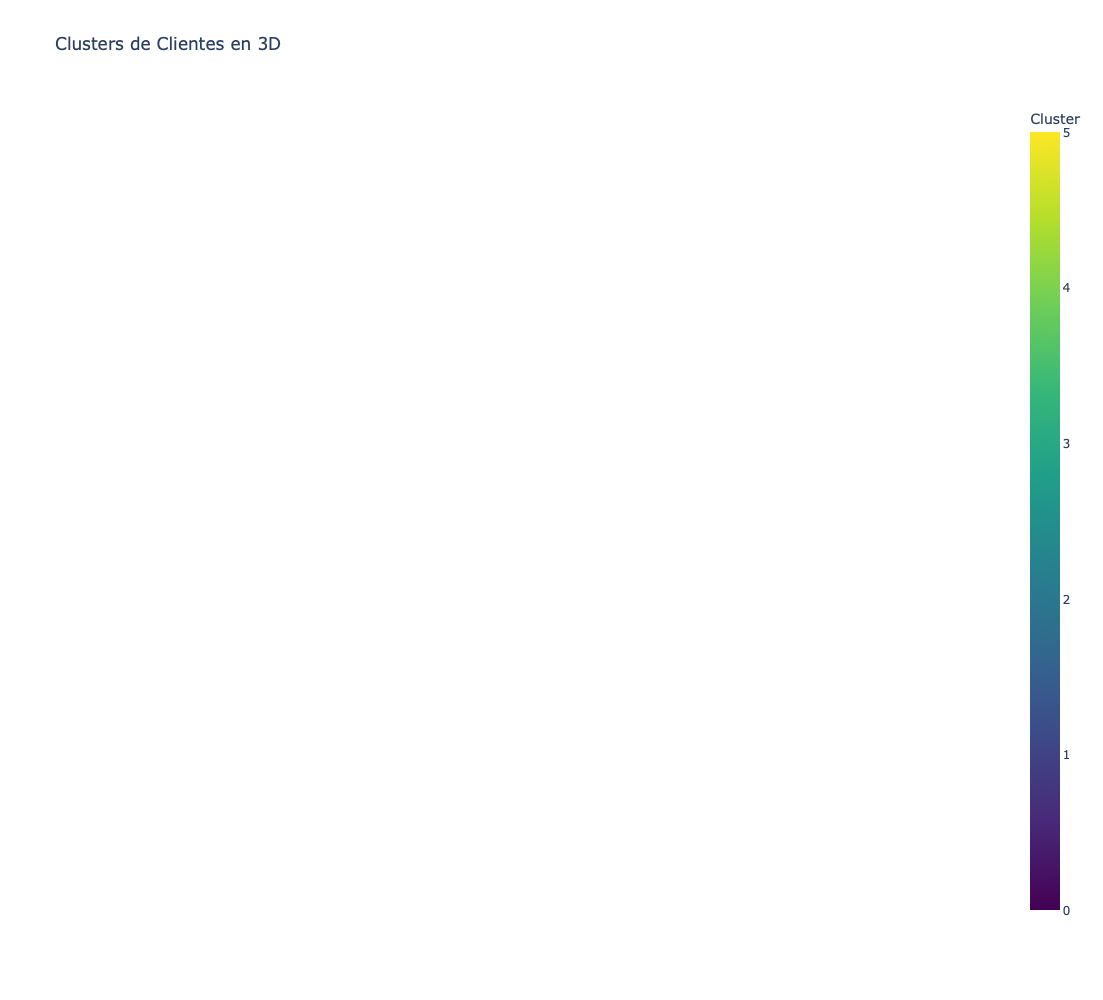

In [75]:
import plotly.express as px

# Crear gráfico 3D interactivo
fig = px.scatter_3d(
    data, 
    x='Age', 
    y='Annual Income (k$)', 
    z='Spending Score (1-100)', 
    color='Cluster', 
    title='Clusters de Clientes en 3D', 
    labels={'Age': 'Age', 'Annual Income (k$)': 'Annual Income (k$)', 'Spending Score (1-100)': 'Spending Score (1-100)'},
    color_continuous_scale='viridis'
)

fig.update_layout(
    width=1000,
    height=1000,
)

fig.show()

Dado el gráfico anterior, podemos visualizar que sí existe una diferencia entre el cluster 0 y 1 que antes no se lograba visualizar con un gráfico 2D. Ésta diferencia se basa principalmente en el grupo etario.

- Con respecto a los diferentes clusters, podemos identificar las siguientes características:

| Cluster | Edad | Ingreso Anual | Spending Score | Descripción |
|---------|------|--------------|----------------|-------------|
| **0** | Adultos (40-70) | Medio (40k-60k) | Medio (40-60) | Clientes racionales |
| **1** | Jóvenes (18-40) | Medio (40k-60k) | Medio (40-60) | Compradores versátiles |
| **2** | Toda edad (18-59) | Alto (70k-137k) | Bajo (5-39) | Clientes ahorradores |
| **3** | Adulto Joven (28-40) | Alto (70k-137k) | Alto (63-97) | Compradores VIP | 
| **4** | Joven (18-35) | Bajo (15k-39k) | Alto (61-99) | Compradores impulsivos | 
| **5** | Toda edad (20-67) | Bajo (16k-39k) | Bajo (3-40) | Clientes conservadores |


## Análisis de los Clusters:

- **Clientes Racionales**: Adultos  con ingresos moderados y un gasto equilibrado. Compran con planificacion y prefieren calidad sobre cantidad
- **Compradores Versátiles**: Jóvenes con estabilidad económica que gastan de forma controlada. Son receptivos a experiencias innovadoras y exclusivas.
- **Clientes Ahorradores Premium**: Personas con alto poder adquisitivo pero poco gasto. Priorizan ahorro e inversión antes que consumo impulsivo.
- **Compradores VIP**: Adultos con ingresos altos y alto gasto. Les atraen experiencias de lujo, exclusividad y compras personalizadas.
- **Compradores Impulsivos**: Jóvenes con ingresos bajos pero alto gasto. Compran por deseo más que por necesidad.
- **Clientes Conservadores**: Personas de bajos ingresos con poco gasto. Compran lo esencial y buscan precios bajos.

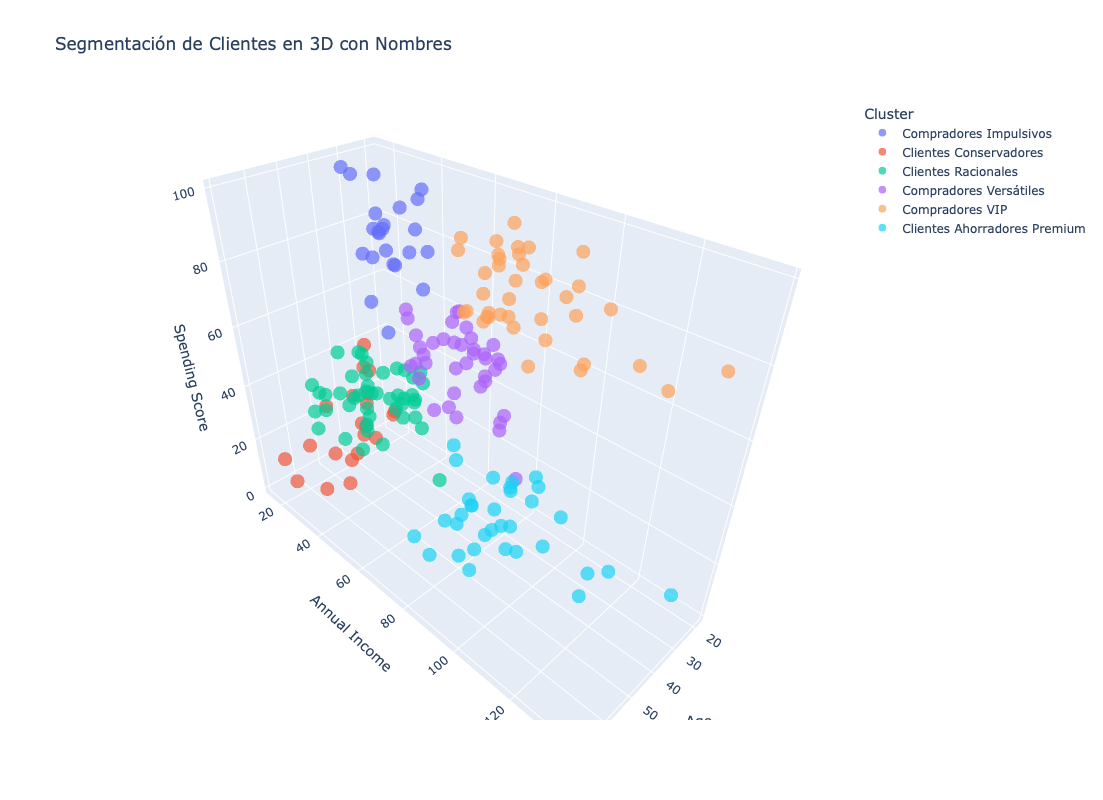

In [79]:
# Ahora que identificamos a nuestros grupos, los vamos a visualizar por sus nombres para su posterior conclusión
# Diccionario con los nombres de los clusters
cluster_labels = {
    0: "Clientes Racionales",
    1: "Compradores Versátiles",
    2: "Clientes Ahorradores Premium",
    3: "Compradores VIP",
    4: "Compradores Impulsivos",
    5: "Clientes Conservadores"
}

# Crear dataframe con información de clusters
df = pd.DataFrame({
    "Annual Income": data["Annual Income (k$)"],
    "Spending Score": data["Spending Score (1-100)"],
    "Age": data["Age"],
    "Cluster": data["Cluster"].map(cluster_labels)  # Usamos nombres en lugar de números
})

# Crear gráfico 3D interactivo
fig = px.scatter_3d(df, x='Age', y='Annual Income', z='Spending Score', color='Cluster',
                     title="Segmentación de Clientes en 3D con Nombres", opacity=0.7)

fig.update_layout(
    width=1100,
    height=800,
)

# Mostrar gráfico
fig.show()


## Conclusión del Análisis

El análisis de clustering ha permitido identificar seis tipos de clientes con diferentes patrones de consumo. Entre ellos, los "Compradores impulsivos", los "Compradores VIP" y los "Compradores versátiles" son los más atractivos para estrategias de marketing debido a su predisposición a gastar.

Se recomienda aplicar estrategias diferenciadas para cada segmento:

- **Compradores Impulsivos**: Ofertas flash, descuentos exclusivos y campañas en redes sociales.
- **Compradores VIP**: Membresías premium, experiencias personalizadas y acceso a eventos exclusivos.
- **Compradores Versátiles**: Programas de fidelización, marketing experiencial y promociones estratégicas.